# RESTfulSwarm


In [823]:
%matplotlib inline
import pymongo as mg
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


# return a mongodb client
def get_client(usr, pwd, address, port='27017'):
    url = 'mongodb://%s:%s@%s:%s/RESTfulSwarmDB' % (usr, pwd, address, port)
    return mg.MongoClient(url)


# return a database object
def get_db(client, db_name):
    return client[db_name]


# return a collection cursor object
def get_col(db, col_name):
    return db[col_name]


# query data in a job collection
def query_col(col):
    return list(col.find({}))[0]


# get a list of job collection name
def get_all_cols(db):
     return db.collection_names()

In [824]:
def get_time(data):
    result = {'waiting_time': 0, 'execution_time': 0, 'total_time': 0}
    if len(data) == 0:
        return None
    submit_time = data['submit_time']
    start_time = data['start_time']
    end_time = data['end_time']
    
    waiting_time = start_time - submit_time
    result['waiting_time'] = waiting_time
    
    execution_time = end_time - start_time
    result['execution_time'] = execution_time
    
    total_time = end_time - submit_time
    result['total_time'] = total_time
    return result


In [825]:
def plot_graph(db):
    cols = get_all_cols(db)
    data = {}
    waiting_time = []
    execution_time = []
    total_time = []
    jobs = []
    for col in cols:
        if 'job' not in col:
            continue
        col_obj = get_col(db, col)
        job_info = query_col(col_obj)
        session = job_info['job_name'].split('-')[1]
        result = get_time(job_info)
        if result['waiting_time'] <= 0 or result['execution_time'] <= 0 or result['total_time'] <= 0:
            continue
        if session not in data:
            data.update({session: {'waiting_time': [], 'execution_time': [], 'total_time': [], 'jobs': []}})
        data[session]['waiting_time'].append(result['waiting_time'])
        data[session]['execution_time'].append(result['execution_time'])
        data[session]['total_time'].append(result['total_time'])
        data[session]['jobs'].append(col)
    return data


In [826]:
client = get_client('admin', 'kzw', '129.114.108.18')
db = get_db(client, 'RESTfulSwarmDB')


In [827]:
def plot_waiting_time(waiting_time, jobs, session):
    wt = pd.Series(waiting_time, index=jobs)
    wt.plot.line(figsize=(20, 10))
    plt.xlabel('Job')
    plt.ylabel('Waiting Time(s)')
    plt.title('Job Waiting Time--%s' % session)

In [828]:
def plot_execution_time(execution_time, jobs, session):
    et = pd.Series(execution_time, index=jobs)
    et.plot.line(figsize=(20, 10))
    plt.xlabel('Job')
    plt.ylabel('Execution Time(s)')
    plt.title('Job Execution Time--%s' % session)


In [829]:
def plot_total_time(total_time, jobs, session):
    tt = pd.Series(total_time, index=jobs)
    tt.plot.line(figsize=(20, 10))
    plt.xlabel('Job')
    plt.ylabel('Total Time(s)')
    plt.title('Job Total Time--%s' % session)


In [830]:
def plot_resource_graph():
    workers_resource_col = get_col(db, 'WorkersResourceInfo')
    data = list(workers_resource_col.find({}))
    hostnames = [worker['hostname'] for worker in data]
    time_stamps = []
    for worker in data:
        for detail in worker['details']:
            time_stamps.append(detail[0])
    time_stamps = list(set(time_stamps))
    time_stamps.sort()
    utilization = np.zeros([len(hostnames), len(time_stamps)])
            
    def search_utilization(hostname, _time_stamp):
        for worker in data:
            if worker['hostname'] == hostname:
                for _detail in worker['details']:
                    if _detail[0] == _time_stamp:
                        return _detail[1]
        return 0
    
    for i, host in enumerate(hostnames[:]):
        for j, time_stamp in enumerate(time_stamps[:]):
            result = search_utilization(host, time_stamp)
            if result != -1:
                utilization[i, j] = result
            else:
                utilization[i, j] = utilization[i, j-1]
    
    df = pd.DataFrame(data=utilization, index=hostnames, columns=time_stamps)
    
    return sns.heatmap(data=df, vmin=0, vmax=1, center=0, cmap="Greens")

In [831]:
import numpy as np
import matplotlib.pyplot as plt


client = get_client('admin', 'kzw', '129.114.108.18')
db = get_db(client, 'RESTfulSwarmDB')

def graph_cdf(data, session):
    num_bins = 10
    counts, bin_edges = np.histogram (data, bins=num_bins, normed=True)
    cdf = np.cumsum (counts)
    print(bin_edges)
    print(counts)

    _label = '"Baseline Application Performance--%s' % session
    plt.plot (bin_edges[1:], cdf/cdf[-1], label=_label)
    plt.xlabel("Response Time in msec.")
    plt.ylabel("F(x)")
    plt.legend()


    for q in [50, 90, 95, 100]:
      print ("{}%% percentile: {}".format (q, np.percentile(data, q)))

In [832]:
graph_data = plot_graph(db)
for session in graph_data:
    waiting_time = graph_data[session]['waiting_time']
    execution_time = graph_data[session]['execution_time']
    jobs = graph_data[session]['jobs']
    plot_waiting_time(waiting_time, jobs, session)

# Waiting Time

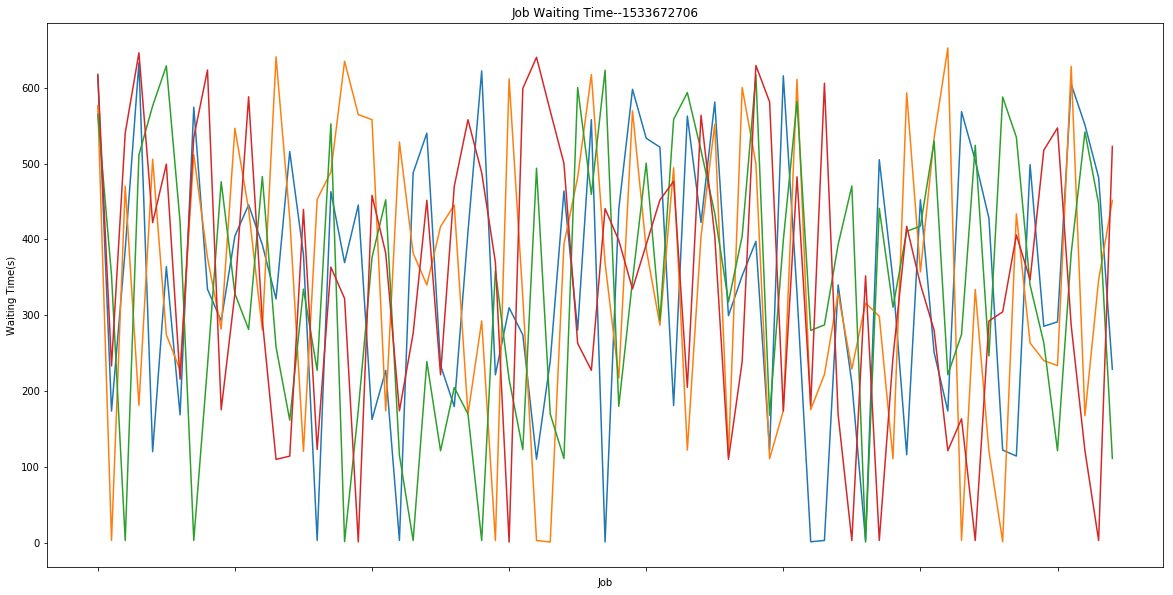

In [833]:
for session in graph_data:
    waiting_time = graph_data[session]['waiting_time']
    jobs = graph_data[session]['jobs']
    plot_waiting_time(waiting_time, jobs, session)

# Execution Time

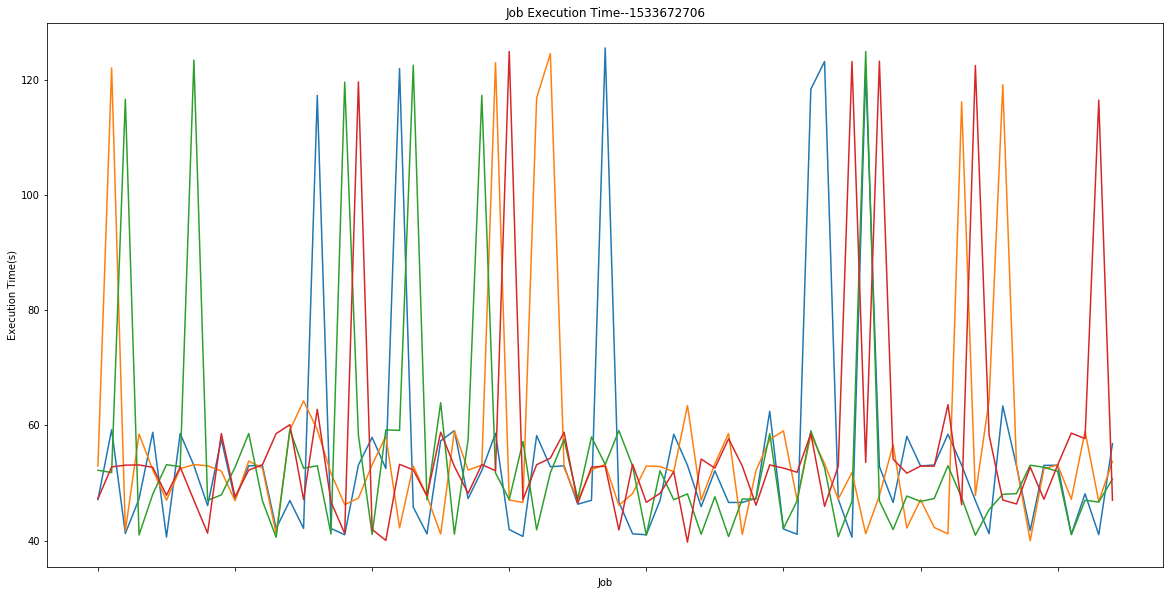

In [834]:
for session in graph_data:
    execution_time = graph_data[session]['execution_time']
    jobs = graph_data[session]['jobs']
    plot_execution_time(execution_time, jobs, session)

# Total Time

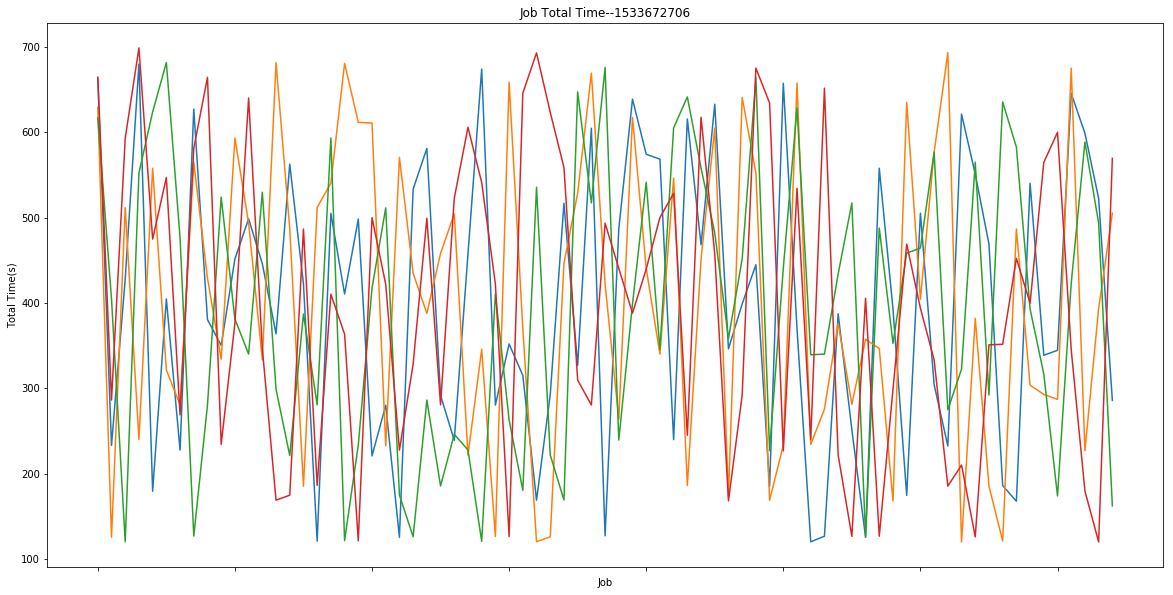

In [835]:
for session in graph_data:
    total_time = graph_data[session]['total_time']
    jobs = graph_data[session]['jobs']
    plot_total_time(total_time, jobs, session)

# Resource Utilization

C:\Users\kangz1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\kangz1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
  'left=%s, right=%s') % (left, right))
C:\Users\kangz1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3443: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0
  'bottom=%s, top=%s') % (bottom, top))
C:\Users\kangz1\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py:3124: UserWarning: Attempting to set identical left==right results
in singular transformations; a

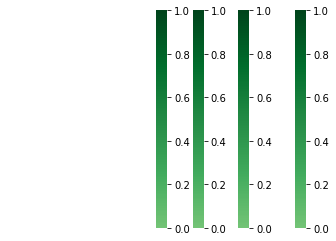

In [836]:
for session in graph_data:
    plot_resource_graph()

# Waiting Time CDF

[  1.36333418  64.52078681 127.67823944 190.83569207 253.9931447
 317.15059733 380.30804996 443.4655026  506.62295523 569.78040786
 632.93786049]
[0.00126668 0.00126668 0.00126668 0.00147779 0.00147779 0.00190001
 0.0016889  0.00211113 0.0016889  0.0016889 ]
50%% percentile: 352.2854428291321
90%% percentile: 572.0290644168854
95%% percentile: 608.0474928855896
100%% percentile: 632.9378604888916
[  1.2781601   66.39927444 131.52038879 196.64150314 261.76261749
 326.88373184 392.00484619 457.12596054 522.24707489 587.36818924
 652.48930359]
[0.00122848 0.00122848 0.00122848 0.00122848 0.00184272 0.00184272
 0.00184272 0.00143323 0.00163797 0.00184272]
50%% percentile: 357.2904326915741
90%% percentile: 597.3689166069031
95%% percentile: 620.5965544223785
100%% percentile: 652.4893035888672
[  1.22588849  63.99018693 126.75448537 189.51878381 252.28308225
 315.04738069 377.81167912 440.57597756 503.340276   566.10457444
 628.86887288]
[0.00127461 0.00127461 0.00127461 0.00148704 0.00169

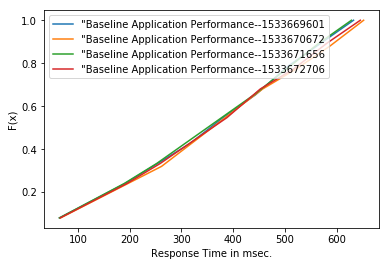

In [837]:
for session in graph_data:
    waiting_time = graph_data[session]['waiting_time']
    graph_cdf(waiting_time, session)

# Execution Time CDF

[ 40.59911442  49.08997974  57.58084507  66.0717104   74.56257572
  83.05344105  91.54430637 100.0351717  108.52603703 117.01690235
 125.50776768]
[0.05810166 0.02983599 0.0204141  0.         0.         0.
 0.         0.         0.         0.00942189]
50%% percentile: 52.1264591217041
90%% percentile: 61.17695350646976
95%% percentile: 119.37768862247466
100%% percentile: 125.50776767730713
[ 40.00135255  48.4512645   56.90117645  65.3510884   73.80100036
  82.25091231  90.70082426  99.15073621 107.60064816 116.05056012
 124.50047207]
[0.04418192 0.04418192 0.02051303 0.         0.         0.
 0.         0.         0.         0.00946755]
50%% percentile: 52.49924063682556
90%% percentile: 63.934129476547255
95%% percentile: 117.52004418373107
100%% percentile: 124.50047206878662
[ 40.59630299  49.02347043  57.45063787  65.8778053   74.30497274
  82.73214018  91.15930762  99.58647506 108.0136425  116.44080994
 124.86797738]
[0.06012301 0.0300615  0.01898621 0.         0.         0.
 0. 

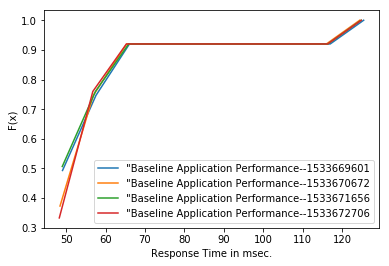

In [838]:
for session in graph_data:
    execution_time = graph_data[session]['execution_time']
    graph_cdf(execution_time, session)

# Total Time CDF

[119.93217778 175.95883787 231.98549795 288.01215804 344.03881812
 400.06547821 456.09213829 512.11879838 568.14545846 624.17211854
 680.19877863]
[0.00214184 0.00118991 0.00190386 0.00142789 0.00237982 0.00166587
 0.00190386 0.00166587 0.00166587 0.00190386]
50%% percentile: 398.92728209495544
90%% percentile: 625.0972579956056
95%% percentile: 649.4346960067749
100%% percentile: 680.198778629303
[119.57751226 176.98649855 234.39548483 291.80447111 349.21345739
 406.62244368 464.03142996 521.44041624 578.84940252 636.25838881
 693.66737509]
[0.00209027 0.00185801 0.00139351 0.00185801 0.00162576 0.00162576
 0.00162576 0.00185801 0.00162576 0.00185801]
50%% percentile: 404.4039011001587
90%% percentile: 638.9006134510041
95%% percentile: 671.361312699318
100%% percentile: 693.667375087738
[119.93321133 176.14548633 232.35776134 288.57003634 344.78231134
 400.99458635 457.20686135 513.41913636 569.63141136 625.84368637
 682.05596137]
[0.00237196 0.00142318 0.00189757 0.00166037 0.001660

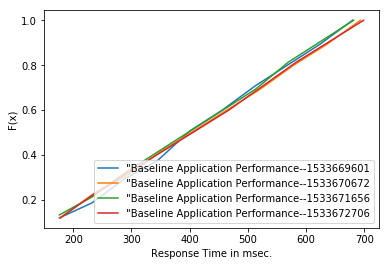

In [839]:
for session in graph_data:
    total_time = graph_data[session]['total_time']
    graph_cdf(total_time, session)